In [1]:
from src.models.egnn import *
from src.models.utils import *


EGNN(
  (layers): ModuleList(
    (0): Linear(in_features=5, out_features=10, bias=True)
    (1-2): 2 x Linear(in_features=10, out_features=10, bias=True)
    (3): Linear(in_features=10, out_features=2, bias=True)
  )
)


In [2]:

#create a model
# Hyperparameters
num_nodes = 6
feature_dim = 1
hidden_dim =10
output_dim = 1
cutoff = 1.5
device = 'cpu'

# Initialize model
model = EGNN(
    in_node_nf=feature_dim,
    hidden_nf=hidden_dim,
    out_node_nf=output_dim,
    n_layers=3
).to(device)

model.train()  # Keep dropout active

node_features, node_coords, edge_index = generate_data(num_nodes, feature_dim, cutoff)
target_coords = update_coordinates(node_coords,node_features)
target_features = torch.norm(node_features)
model.forward_with_uncertainty(node_features, node_coords, edge_index)


((tensor([[-0.1044],
          [-0.1213],
          [-0.1161],
          [-0.1174],
          [-0.1079],
          [-0.1029]], grad_fn=<MeanBackward1>),
  tensor(0.0161, grad_fn=<MeanBackward0>)),
 (tensor([[0.5264, 0.1540],
          [0.9918, 0.3277],
          [0.7347, 0.0501],
          [0.2242, 0.9223],
          [0.7990, 0.3257],
          [0.4714, 0.5287]], grad_fn=<MeanBackward1>),
  tensor(0.5047, grad_fn=<MeanBackward0>)))

In [3]:
# Hyperparameters
num_nodes = 6
feature_dim = 1
hidden_dim =10
output_dim = 1
cutoff = 1.5
device = 'cpu'
n_samples=10
# Example: Prune weights, freeze pruned parameters, and train on uncertain data
# Example model instantiation and optimizer setup
model = EGNN(
    in_node_nf=feature_dim,
    hidden_nf=hidden_dim,
    out_node_nf=output_dim,
    n_layers=3
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
k=0
j=0
model.train()  # Set model to training mode
loss_fn = nn.MSELoss()
# train a model selecting these elements of the training set that are below an uncertainty (h_uncertainty > 0.0002) & (x_uncertainty > 0.6)
while j<200:
    train_data = generate_data(num_nodes, feature_dim, cutoff)
    # Uncertainty sampling for training
    node_features, node_coords, edge_indices = train_data  # Assuming train_data is in this format
    target_coords=update_coordinates(node_coords, node_features)
    target_h=torch.norm(node_features)
    # Get mean predictions and uncertainties
    (h_mean, h_uncertainty), (x_mean, x_uncertainty) = model.forward_with_uncertainty(node_features, node_coords, edge_indices, n_samples)
    # Use uncertainty to filter out high-uncertainty predictions for training
    mask = (h_uncertainty > 0.0002) & (x_uncertainty > 0.7)
    # mask = (x_uncertainty > 0.5)
    # print("uncer hx",h_uncertainty.item(),x_uncertainty.item())
    if (mask and j<200):
        # Perform pruning
        prune_weights(model)
        # Freeze pruned parameters
        freeze_parameters(model)
        # Apply the mask to h_mean and x_mean (you need to ensure that the mask applies element-wise)
        optimizer.zero_grad()
        loss_coord = loss_fn(target_coords,x_mean)  # Compute loss on uncertain data
        loss_h= loss_fn(target_h,torch.norm(h_mean))
        loss= loss_coord+0.0*loss_h
        loss.backward()
        optimizer.step()
        print("Got example",loss.item(),"looshx", loss_h.item(),loss_coord.item(),"uncertx",x_uncertainty,j,k)
        j+=1
    if ((k<200) and (mask==False)):
        optimizer.zero_grad()
        loss_coord = loss_fn(target_coords,x_mean)  # Compute loss on uncertain data
        loss_h= loss_fn(target_h,torch.norm(h_mean))
        loss= loss_coord+0.00*loss_h
        loss.backward()
        optimizer.step()
        print("loss",loss.item(),k)
        k+=1
print(k+j)

loss 0.04930133745074272 0
loss 0.03286547213792801 1
loss 0.0327131412923336 2
loss 0.01496561337262392 3
loss 0.018054941669106483 4
loss 0.015099638141691685 5
loss 0.020451869815587997 6
loss 0.013500969856977463 7
Got example 0.028154252097010612 looshx 1.244702935218811 0.028154252097010612 uncertx tensor(0.7102, grad_fn=<MeanBackward0>) 0 8
loss 0.025674059987068176 8
loss 0.014373533427715302 9
loss 0.029692530632019043 10
loss 0.034306593239307404 11
loss 0.018139880150556564 12
loss 0.01150169875472784 13
loss 0.027780987322330475 14
loss 0.019819026812911034 15
loss 0.009010657668113708 16
loss 0.01625998318195343 17
loss 0.003098102519288659 18
Got example 0.029427727684378624 looshx 1.2644520998001099 0.029427727684378624 uncertx tensor(0.7012, grad_fn=<MeanBackward0>) 1 19
loss 0.005794097203761339 19
Got example 0.015460394322872162 looshx 1.407173752784729 0.015460394322872162 uncertx tensor(0.7210, grad_fn=<MeanBackward0>) 2 20
loss 0.019100842997431755 20
loss 0.01159

In [4]:
#train a baseline model 100 epochs
# Hyperparameters
num_nodes = 6
feature_dim = 1
hidden_dim =10
output_dim = 1
cutoff = 1.5
device = 'cpu'
n_samples=10
# Example: Prune weights, freeze pruned parameters, and train on uncertain data
# Example model instantiation and optimizer setup
egnn2 = EGNN(
    in_node_nf=feature_dim,
    hidden_nf=hidden_dim,
    out_node_nf=output_dim,
    n_layers=3
).to(device)
optimizer = torch.optim.Adam(egnn2.parameters(), lr=1e-3)
k=0
j=0
egnn2.train()  # Set model to training mode
loss_fn = nn.MSELoss()

while j<400:
    train_data = generate_data(num_nodes, feature_dim, cutoff)
    # Perform pruning
    # prune_weights(egnn2)
    # # Freeze pruned parameters
    # freeze_parameters(egnn2)
    # Uncertainty sampling for training
    node_features, node_coords, edge_indices = train_data  # Assuming train_data is in this format
    target_coords=update_coordinates(node_coords, node_features)
    target_h=torch.norm(node_features)
    # Get mean predictions and uncertainties
    (h_mean, h_uncertainty), (x_mean, x_uncertainty) = egnn2.forward_with_uncertainty(node_features, node_coords, edge_indices, n_samples)
    # Use uncertainty to filter out high-uncertainty predictions for training
    mask = (h_uncertainty < 0.03) & (x_uncertainty < 0.4)
    mask = (x_uncertainty < 0.6)
    mask = True
    # print("uncer hx",h_uncertainty.item(),x_uncertainty.item())
    if mask:
        # Apply the mask to h_mean and x_mean (you need to ensure that the mask applies element-wise)
        optimizer.zero_grad()
        loss_coord = loss_fn(target_coords,x_mean)  # Compute loss on uncertain data
        loss_h= loss_fn(target_h,torch.norm(h_mean))
        loss= loss_coord+0.0*loss_h
        loss.backward()
        optimizer.step()
        # print("Got example",loss.item(),"looshx", loss_h.item(),loss_coord.item(),"uncertx",x_uncertainty,j)
        j+=1
        k+=1
    # if k<100:
    #     optimizer.zero_grad()
    #     loss_coord = loss_fn(target_coords,x_mean)  # Compute loss on uncertain data
    #     loss_h= loss_fn(target_h,torch.norm(h_mean))
    #     loss= loss_coord+0.00*loss_h
    #     loss.backward()
    #     optimizer.step()
print("loss",loss.item(),k)
    #     k+=1


loss 0.004231675527989864 400


Error Pruned - Error baseline -0.0003321294207125902 0.6098178029060364 0.6140052080154419


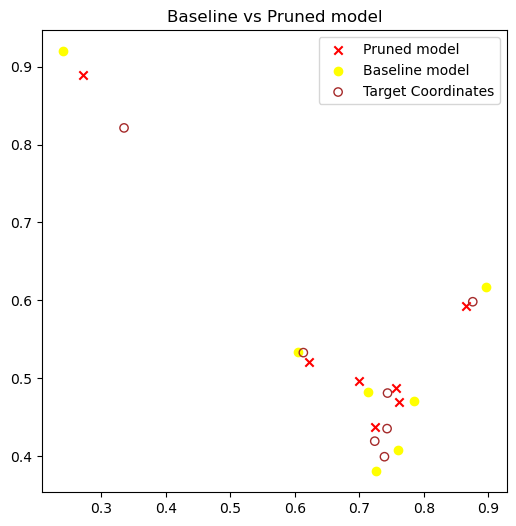

-0.0003321294207125902


In [9]:
#now plot the results the red coordinatres yellow dots coordinates baseline and red dots our model
egnn2.eval()
model.eval()
n_samples=10
num_nodes =7
loss_fn = nn.MSELoss()
a=0
for _ in range(10):
    train_data = generate_data(num_nodes, feature_dim, cutoff)
    node_features, node_coords, edge_indices = train_data  # Assuming train_data is in this format
    target_coords=update_coordinates(node_coords, node_features)
    target_h=torch.norm(node_features)
    (h_mean, h_uncertainty), (x_mean, x_uncertainty) = model.forward_with_uncertainty(node_features, node_coords,edge_indices)
    if x_uncertainty.item()>0.6:
        
        loss_coordm = loss_fn(target_coords,x_mean)
        (h_mean, h_uncertainty), (x_mean2, x_uncertainty2) = egnn2.forward_with_uncertainty(node_features, node_coords, edge_indices)
        loss_coordegnn2 = loss_fn(target_coords,x_mean2)
        a+=loss_coordm.item()-loss_coordegnn2.item()
        # print((x_uncertainty-x_uncertainty2).item())
        print("Error Pruned - Error baseline",loss_coordm.item()-loss_coordegnn2.item(),x_uncertainty2.item(),x_uncertainty.item())
        plt.figure(figsize=(6, 6))
        # plt.scatter(node_coords[:, 0], node_coords[:, 1], color='blue', label='Original Coordinates')
        plt.scatter(x_mean.detach().numpy()[:, 0], x_mean.detach().numpy()[:, 1], color='red',marker='x',label='Pruned model')
        plt.scatter(x_mean2.detach().numpy()[:, 0], x_mean2.detach().numpy()[:, 1], color='yellow',label='Baseline model')
        plt.scatter(target_coords[:, 0], target_coords[:, 1], color='brown',facecolors='none',label='Target Coordinates')
        # plt.scatter(dif[:, 0], dif[:, 1], color='yellow', label='diff')
        plt.legend()
        plt.title("Baseline vs Pruned model")
        plt.show()
print(a)
